**Classifier** è la classe padre dei nostri due modelli (k nearest neighbors and decision trees). Lo usiamo per implementare metodi comuni per i nostri modelli

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


class Classifier:
    @staticmethod
    def evaluate_acc(true_labels, target_labels):
        """Valutare la precisione del modello"""
        accuracy = np.sum(true_labels == target_labels) / len(true_labels)
        return accuracy

    @staticmethod
    def plot_decision_bound(features, labels, f1_name, f2_name, model, **kwargs):

        labels = labels.flatten()
        mod = model(**kwargs)

        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.33, random_state=1234
        )

        mod.fit(X_train, y_train)
        x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
        y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2), np.arange(y_min, y_max, 0.2))
        if type(mod).__name__ == "DecisionTree":
            predictions = np.argmax(
                mod.predict(np.c_[xx.ravel(), yy.ravel()]), 1
            ).reshape(xx.shape)
        else:
            predictions = mod.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        plt.figure()
        plt.contourf(xx, yy, predictions, alpha=0.4)
        plt.scatter(features[:, 0], features[:, 1], c=labels)
        plt.xlabel(f1_name)
        plt.ylabel(f2_name)
        plt.xticks()
        plt.yticks()
        plt.show()

    @staticmethod
    def plot_confusion_matrix(features, labels, model, l1, l2, **kwargs):
        """Tracciate la matrice di confusione di un modello. l1 e l2 sono le due classi"""
        mod = model(**kwargs)
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.33
        )

        mod.fit(X_train, y_train)
        predictions = mod.predict(X_test)
        if type(mod).__name__ == "DecisionTree":
            predictions = np.argmax(predictions, 1)
        TP, TN, FP, FN = 0, 0, 0, 0

        for i in range(len(predictions)):
            if predictions[i] == y_test[i] == l1:
                TP += 1
            elif predictions[i] == y_test[i] == l2:
                TN += 1
            elif predictions[i] != y_test[i] and predictions[i] == l1:
                FP += 1
            else:
                FN += 1
        confusion_matrix = [[TP, FP], [FN, TN]]

        sns.heatmap(confusion_matrix, annot=True)
        plt.ylabel("Predicted Class")
        plt.xlabel("True Class")
        plt.yticks(ticks=[0.5, 1.5], labels=[l1, l2])
        plt.xticks(ticks=[0.5, 1.5], labels=[l1, l2])
        plt.title("Confusion matrix")
        plt.show()

    @staticmethod
    def get_mean_accuracy(
        model, X_train, X_test, y_train, y_test, n, training=False, **kwargs
    ):
        """restituisce l'accuratezza di KNN prendendo l'accuratezza media di n iterazioni"""
        accuracy = []
        for _ in range(n):
            mod = model(**kwargs)
            mod.fit(X_train, y_train)
            if training:
                X_test = X_train
                y_test = y_train
            predictions = mod.predict(X_test)
            if type(mod).__name__ == "DecisionTree":
                predictions = np.argmax(predictions, 1)
            accuracy.append(mod.evaluate_acc(predictions, y_test))
        return np.array(accuracy).mean()

Modello K-nearest neighbors

In [39]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance


class KNN(Classifier):
    """Classificazione K-NN"""

    def __init__(self, k=1, dist_fn=distance.minkowski, p=2):
        self.k = k
        self.dist_fn = dist_fn
        # p è l'ordine della norma nella distanza di Minkowski (2 = euclideo)
        self.p = p

    def fit(self, x, y):
        """Memorizza il train data"""
        self.train_x = x
        self.train_y = y

    def predict(self, X_test):
        """Predizioni Output"""
        predictions = [self._predict_instance(x_test) for x_test in X_test]
        return np.array(predictions)

    def _predict_instance(self, x):
        distances = [self.dist_fn(x, train_x, self.p) for train_x in self.train_x]
        sorted_dist = np.argsort(distances)

        # ottenere indici k nearest neighbors
        knn_indices = sorted_dist[: self.k]
        # ottenere etichetta dagli indici del k nearest neighbors
        knn_labels = [self.train_y[index] for index in knn_indices]
        return Counter(knn_labels).most_common(1)[0][0]

    @staticmethod
    def cross_validate(k, n, df, p_dist=2, training=False):
        """Quando il parametro di training è True, l'accuratezza del modello
        viene testato sulla base di esempi su cui è stato costruito"""
        acc = []
        # restituire un campione casuale di articoli
        df.sample(frac=1)
        num_rows = df.shape[0]
        num_folds_row = num_rows // k

        for f in range(k):
            test = df[f * num_folds_row : f * num_folds_row + num_folds_row]
            if training:
                train = df[df.index.isin(test.index)]
            else:
                train = df[~df.index.isin(test.index)]
            train_x, train_y = (
                train.drop("Class", axis=1).to_numpy(),
                train["Class"].to_numpy(),
            )
            test_x, test_y = (
                test.drop("Class", axis=1).to_numpy(),
                test["Class"].to_numpy(),
            )

            classifier_knn = KNN(n, p=p_dist)
            classifier_knn.fit(train_x, train_y)
            predictions = classifier_knn.predict(test_x)
            acc.append(classifier_knn.evaluate_acc(predictions, test_y))
        return np.array(acc).mean()

    @staticmethod
    def tune_knn_k(df, training=False):
        """Utilizzare la convalida incrociata k-fold per ottimizzare l'iperparametro K
        e tracciare l'accuratezza per diversi iperparametri K"""
        scores = []
        ks = np.arange(1, 10)
        folds = 10
        for k in ks:
            accuracy = KNN.cross_validate(folds, k, df, training=training)
            scores.append(accuracy)

        plt.plot(ks, scores, linewidth=4, markersize=10)
        plt.grid()
        plt.xlabel("K in K-nearest Neighbors")
        if training:
            plt.ylabel("Cross Validation Train Accuracy")
        else:
            plt.ylabel("Cross Validation Test Accuracy")
        plt.show()

        # K con maggiore accuratezza
        return np.array(scores).argmax() + 1

    @staticmethod
    def tune_knn_p(df, training=False):
        """Utilizzare la convalida incrociata k-fold per ottimizzare l'iperparametro P
        e tracciare l'accuratezza per diversi iperparametri P"""
        scores = []
        ps = np.arange(1, 16)
        folds = 10
        for p in ps:
            accuracy = KNN.cross_validate(folds, 5, df, p_dist=p)
            scores.append(accuracy)

        plt.plot(ps, scores, linewidth=4, markersize=10)
        plt.grid()
        plt.xlabel("P in K-nearest Neighbors's minkowski distance function")
        if training:
            plt.ylabel("Cross Validation Train Accuracy")
        else:
            plt.ylabel("Cross Validation Test Accuracy")
        plt.show()

        # p con maggiore accuratezza
        return np.array(scores).argmax() + 1


Modello Decision tree

In [40]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)  

class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices  # memorizza gli indici di dati che si trovano nell'area definita da questo nodo
        self.left = None  # Memorizza il figlio sinistro del nodo
        self.right = None  # memorizza il figlio destro del nodo
        self.split_feature = None  # La funzione per dividere in questo nodo
        self.split_value = None  # Valore della funzione per la divisione in questo nodo
        if parent:
            self.depth = (
                parent.depth + 1
            )  # ottenere la profondità del nodo aggiungendo uno alla profondità del genitore 

            self.num_classes = (
                parent.num_classes
            )  # copia le classi num dall'elemento padre
            self.data = parent.data  # copia i dati dall'elemento padre
            self.labels = parent.labels  # copia le etichette dal padre
            class_prob = np.bincount(
                self.labels[data_indices], minlength=self.num_classes
            )  # Sta contando la frequenza di diverse etichette nella regione definita da questo nodo
            self.class_prob = class_prob / np.sum(
                class_prob
            )  # memorizza la probability class per il nodo

def greedy_test(node, cost_fn):
    # inizializzare i migliori valori dei parametri
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    # ordinare le caratteristiche per ottenere i candidati del valore di test prendendo la media delle caratteristiche ordinate consecutivi 
    data_sorted = np.sort(node.data[node.data_indices], axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.0
    for f in range(num_features):
        # memorizza i dati corrispondenti alla funzione f-esima 
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:, f]:
            # Divide gli indici usando il valore di prova della funzione f-esima 
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            # non possiamo avere una divisione in cui un figlio ha zero elementi 
            # se questo è vero per tutte le caratteristiche di test e i loro valori di test, la funzione restituisce il miglior costo come infinito
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            # calcola il costo sinistro e destro in base alla divisione corrente
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            # ottenere il costo combinato utilizzando la somma ponderata del costo sinistro e destro 
            cost = (num_left * left_cost + num_right * right_cost) / num_instances
            # aggiornare solo quando si riscontra un costo inferiore 
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value


# calcola il costo di errata classificazione sottraendo la probabilità massima di qualsiasi classe 
def cost_misclassification(labels):
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    return 1 - np.max(class_probs)


# calcola l'entropia delle etichette calcolando le probability class 
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[
        class_probs > 0
    ]  
    return -np.sum(
        class_probs * np.log(class_probs)
    )  # espressione per l'entropia -\sigma p(x)log[p(x)] 


# calcola il costo dell'indice Gini 
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(
        np.square(class_probs)
    )  # espressione per indice Gini 1-\sigma p(x)^2 


class DecisionTree(Classifier):
    def __init__(
        self,
        num_classes=None,
        max_depth=3,
        cost_fn=cost_misclassification,
        min_leaf_instances=1,
    ):
        self.max_depth = max_depth  # profondità massima per la terminazione
        self.root = None  # memorizza la radice dell'albero decisionale
        self.cost_fn = cost_fn  # memorizza la funzione di costo dell'albero decisionale 
        self.num_classes = num_classes  # memorizza il numero totale di classi 
        self.min_leaf_instances = (
            min_leaf_instances  # numero minimo di istanze in una foglia per la terminazione 
        )

    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        if self.num_classes is None:
            self.num_classes = np.max(labels) + 1
        # inizializzazione della radice dell'albero decisionale 
        self.root = Node(np.arange(data.shape[0]), None)
        self.root.data = data
        self.root.labels = labels
        self.root.num_classes = self.num_classes
        self.root.depth = 0
        # per costruire ricorsivamente il resto dell'albero
        self._fit_tree(self.root)

    def predict(self, data_test):
        class_probs = np.zeros((data_test.shape[0], self.num_classes))
        for n, x in enumerate(data_test):
            node = self.root
            # ciclo lungo la profondità della regione ad albero in cui rientra il campione di dati presente in base alla funzione e al valore di suddivisione split 
            while node.left:
                if x[node.split_feature] <= node.split_value:
                    node = node.left
                else:
                    node = node.right
            # il ciclo termina quando raggiungi una foglia dell'albero e la probability class di quel nodo viene presa per la previsione 
            class_probs[n, :] = node.class_prob
        return class_probs

    def _fit_tree(self, node):
        # Questo dà la condizione per la terminazione della ricorsione risultante in un nodo foglia
        if (
            node.depth == self.max_depth
            or len(node.data_indices) <= self.min_leaf_instances
        ):
            return
        # selezionare il miglior test minimizzando il costo 
        cost, split_feature, split_value = greedy_test(node, self.cost_fn)
        # se il costo restituito è infinito significa che non è possibile dividere il nodo e quindi terminare 
        if np.isinf(cost):
            return
        # per ottenere un array booleano che suggerisca quali indici di dati corrispondenti a questo nodo si trovano a sinistra della divisione 
        test = node.data[node.data_indices, split_feature] <= split_value
        # memorizzare la funzione di divisione e il valore del nodo 
        node.split_feature = split_feature
        node.split_value = split_value
        # definire nuovi nodi che saranno il figlio sinistro e destro del nodo attuale 
        left = Node(node.data_indices[test], node)
        right = Node(node.data_indices[np.logical_not(test)], node)
        # chiamata ricorsiva a _fit_tree() 
        self._fit_tree(left)
        self._fit_tree(right)
        # assegna il figlio sinistro e destro al figlio presente 
        node.left = left
        node.right = right

    @staticmethod
    def tune_tree_depth(X_train, X_test, y_train, y_test, training=False):
        scores = []
        ds = np.arange(1, 16)
        for d in ds:
            accuracy = Classifier.get_mean_accuracy(
                DecisionTree,
                X_train,
                X_test,
                y_train,
                y_test,
                5,
                training=training,
                max_depth=d,
            )
            scores.append(accuracy)

        plt.plot(ds, scores, linewidth=4, markersize=10)
        plt.grid()
        plt.xlabel("Depth in decision tree")
        if training:
            plt.ylabel("Cross Validation Train Accuracy")
        else:
            plt.ylabel("Cross Validation Test Accuracy")
        plt.show()

        # la profondità con la massima precisione 
        return np.array(scores).argmax() + 1

    @staticmethod
    def tune_costfn(X_train, X_test, y_train, y_test, depth):
        scores = []
        cost_fns = [cost_misclassification, cost_entropy, cost_gini_index]
        for cost_fn in cost_fns:
            accuracy = Classifier.get_mean_accuracy(
                DecisionTree,
                X_train,
                X_test,
                y_train,
                y_test,
                5,
                max_depth=depth,
                cost_fn=cost_fn,
            )
            scores.append(accuracy)

        print(scores)
        plt.bar(x=[1, 2, 3], height=scores)
        plt.xlabel("Cost function")
        plt.xticks(
            ticks=[1, 2, 3],
            labels=["cost misclassification", "cost entropy", "cost gini index"],
        )
        plt.ylabel("Accuracy")
        plt.show()

        # la profondità con la massima precisione
        return cost_fns[np.array(scores).argmax()]

Il preprocessore acquisisce i dati dai set di dati e li prepara per i nostri modelli pulendoli.

In [41]:
import pandas as pd
from enum import Enum


class Dataset(Enum):
    breast_cancer = 1
    hepatitis = 2


class Preprocessing:
    """Acquisizione, Analisi e Pulizia dati

    Abbiamo utilizzato i seguenti dataset:
    - Dataset 1: breast cancer wisconsin.csv (Breast Cancer dataset):
         https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
    - Dataset 2: hepatitis.csv (Hepatitis dataset):
         http://archive.ics.uci.edu/ml/datasets/Hepatitis
    """

    DATASET1 = "../data/breast_cancer_wisconsin.csv"
    DATASET2 = "../data/hepatitis.csv"

    def __init__(self, dataset):
        """acquisizione dati"""
        # caricare i dataset nel dataframe di pandas
        if dataset == Dataset.breast_cancer:
            self.df = pd.read_csv(Preprocessing.DATASET1, na_values="?")
        elif dataset == Dataset.hepatitis:
            self.df = pd.read_csv(Preprocessing.DATASET2, na_values="?")
        else:
            raise IndexError("Dataset enumeration between 1 and 2")

    def clean(self):
        print("Cleaning dataset ...")
        self.df = self._remove_duplicate_rows()
        self.df = self._remove_empty_rows()

        # elimina le colonne ID non rilevanti
        self.df.drop("id", axis=1, inplace=True, errors="ignore")
        print("\nDropped irrelevant features")

        # imposta la colonna della classe in prima posizione 
        class_col = self.df.pop("Class")
        self.df.insert(0, "Class", class_col)
        print("Set class column to the first position")

        self.df.reset_index(drop=True, inplace=True)
        print("Reset indices")

    def _remove_empty_rows(self):
        """rimuovere le righe contenenti una colonna con un valore vuoto"""
        clean_df = self.df.dropna()
        rows_removed = Preprocessing._rows_removed(self.df, clean_df)
        percentage_removed = Preprocessing._percentage_removed(rows_removed, self.df)
        print(
            "\nRemoved empty rows: \nRemoved {percentage}% of rows \n{count} rows removed".format(
                percentage=percentage_removed, count=rows_removed
            )
        )
        return clean_df

    def _remove_duplicate_rows(self):
        """rimuove le righe con tutte le funzioni duplicate"""
        clean_df = self.df.drop_duplicates()
        rows_removed = Preprocessing._rows_removed(self.df, clean_df)
        percentage_removed = Preprocessing._percentage_removed(rows_removed, self.df)
        print(
            "\nRemoved duplicate rows: \nRemoved {percentage}% of rows \n{count} rows removed".format(
                percentage=percentage_removed, count=rows_removed
            )
        )
        return clean_df

    def normalize_features(self):
        class_col = self.df.pop("Class")
        self.df = (self.df - self.df.min()) / (self.df.max() - self.df.min())
        self.df.insert(0, "Class", class_col)

    _rows_removed = lambda df1, df2: abs(df1.shape[0] - df2.shape[0])
    _percentage_removed = lambda removed, df: round(100 * removed / df.shape[0], 2)

    @staticmethod
    def get_preprocessed_datasets(normalize_features=True):
        # Carica set di dati in un preprocessore
        cancer_preprocessor = Preprocessing(Dataset.breast_cancer)
        hepatitis_preprocessor = Preprocessing(Dataset.hepatitis)

        # Pulizia dei dati
        print("Cleaning hepatitis dataset")
        hepatitis_preprocessor.clean()

        print("\nCleaning breat cancer dataset")
        cancer_preprocessor.clean()
        if normalize_features:
            hepatitis_preprocessor.normalize_features()
            cancer_preprocessor.normalize_features()
        return cancer_preprocessor.df, hepatitis_preprocessor.df

    @staticmethod
    def get_labels_features(df):
        """separa le etichette e le caratteristiche in un set di dati e le restituisce"""
        dframe = df.copy(deep=True)
        labels = dframe.pop("Class").to_numpy()
        features = dframe.to_numpy()
        return features, labels

Usiamo il modulo di visualizzazione come classe di supporto nell'analisi dei nostri 2 set di dati 

In [42]:
import pandas as pd
from pandas.plotting import parallel_coordinates as pc
import matplotlib.pyplot as plt
import seaborn as sns


def class_countplot(df):
    """Frequenze e conteggio della classe di stampa"""

    perc = df["Class"].value_counts(normalize=True) * 100
    perc1, perc2 = "{:.2f}".format(perc.iloc[0]), "{:.2f}".format(perc.iloc[1])
    msg = "Percentages: {perc1}% vs {perc2}%".format(perc1=perc1, perc2=perc2)
    sns.countplot(x="Class", data=df)
    plt.title("Class frequency table\n" + msg)
    plt.ylabel("Number of cases per class")
    plt.xlabel("Classes")
    plt.show()


def feature_hist(df):
    df.hist(grid=False)
    plt.title("Feature histograms")
    plt.show()


def feature_scatter_box(x, df):
    sns.swarmplot(y=df["Class"], x=df[x], color="0.2", orient="h")
    sns.boxplot(y=df["Class"], x=df[x], orient="h")
    plt.show()


# Analisi multivariata
def correlation(df, plot=True):
    """Heatmap (matrice di correlazione a coppie)"""

    # trova le caratteristiche più correlate alla classe 
    correlation = df.corrwith(df["Class"]).abs().sort_values(ascending=False)
    if plot:
        heatmap = df.corr()
        sns.heatmap(heatmap, annot=True, cmap="coolwarm")
        plt.title("Correlation matrix")
        plt.show()

    return correlation


def parallel_coordinates(df):
    """Grafico coordinate parallele"""

    frame = df.apply(lambda x: x / x.max(), axis=0)
    pc(frame, "Class", color=("#FF1493", "#008000"))
    plt.show()


def three_d_plot(x, y, z, df):
    ax = plt.axes(projection="3d")
    ax.scatter(
        xs=df[x], ys=df[y], zs=df[z], c=df["Class"], cmap="viridis", linewidth=0.5
    )
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    plt.show()

Si eseguono alcune analisi sui set di dati

In [43]:
def print_stats(df):
    shape = df.shape
    print(
        "\nDataset contains {rows} rows and {columns} features".format(
            rows=shape[0], columns=shape[1] - 1
        )
    )
    print(df.describe())


cancer_df, hepatitis_df = Preprocessing.get_preprocessed_datasets()

# Analisi invariate
# -----------------------------------------------------------------------------

# stampa statistiche di base sui set di dati
print("breat cancer dataset")
print_stats(cancer_df)
print("hepatitis dataset")
print_stats(hepatitis_df)

Cleaning hepatitis dataset
Cleaning dataset ...

Removed duplicate rows: 
Removed 0.0% of rows 
0 rows removed

Removed empty rows: 
Removed 48.39% of rows 
75 rows removed

Dropped irrelevant features
Set class column to the first position
Reset indices

Cleaning breat cancer dataset
Cleaning dataset ...

Removed duplicate rows: 
Removed 1.14% of rows 
8 rows removed

Removed empty rows: 
Removed 2.32% of rows 
16 rows removed

Dropped irrelevant features
Set class column to the first position
Reset indices
breat cancer dataset

Dataset contains 675 rows and 9 features
            Class  Clump_Thickness  ...  Normal_Nucleoli     Mitoses
count  675.000000       675.000000  ...       675.000000  675.000000
mean     2.699259         0.383539  ...         0.209547    0.067490
std      0.954413         0.313429  ...         0.340623    0.193445
min      2.000000         0.000000  ...         0.000000    0.000000
25%      2.000000         0.111111  ...         0.000000    0.000000
50%      

Breast Cancer class distribution


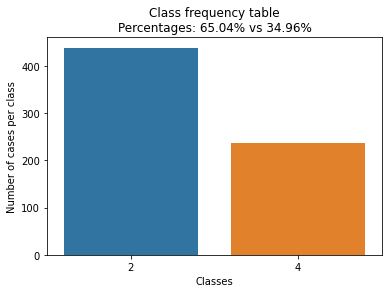

Hepatitis class distribution


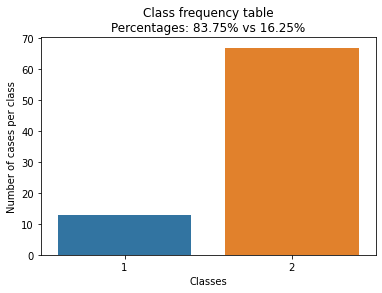

In [44]:
# distribuzione dei casi positivi vs negativi
print("Breast Cancer class distribution")
class_countplot(cancer_df)
print("Hepatitis class distribution")
class_countplot(hepatitis_df)

Histogram of Breast Cancer features


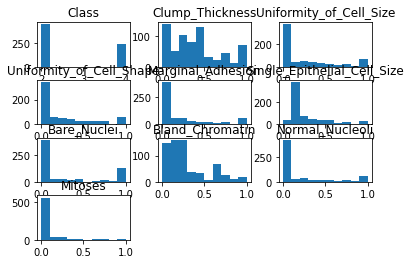

Histogram of Hepatitis features


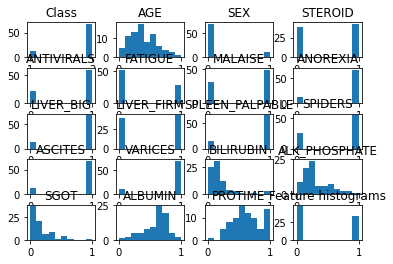

In [45]:
# disegna istogramma
print("Histogram of Breast Cancer features")
feature_hist(cancer_df)
print("Histogram of Hepatitis features")
feature_hist(hepatitis_df)


Breast cancer dataset correlation matrix


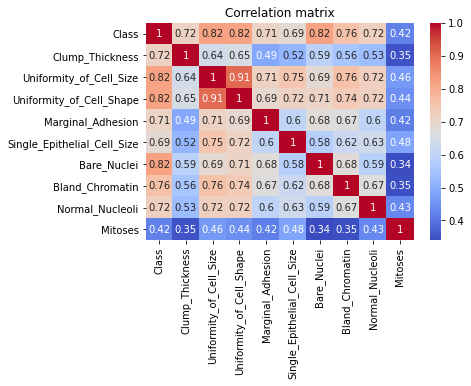


Cancer dataset most decisive features Class                          1.000000
Uniformity_of_Cell_Shape       0.820688
Uniformity_of_Cell_Size        0.820663
Bare_Nuclei                    0.820533
Bland_Chromatin                0.758252
Normal_Nucleoli                0.722020
Clump_Thickness                0.715714
Marginal_Adhesion              0.710985
Single_Epithelial_Cell_Size    0.689544
Mitoses                        0.424399
dtype: float64

Hepatitis dataset correlation matrix


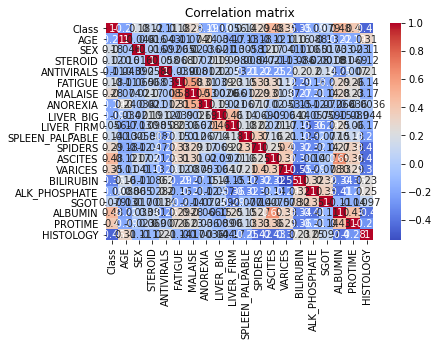


Hepatitis dataset most decisive features Class              1.000000
ASCITES            0.479211
ALBUMIN            0.477404
HISTOLOGY          0.456856
PROTIME            0.395386
BILIRUBIN          0.351557
VARICES            0.345785
SPIDERS            0.287839
MALAISE            0.275595
AGE                0.212769
LIVER_BIG          0.194030
ALK_PHOSPHATE      0.189360
ANOREXIA           0.185042
FATIGUE            0.181151
SEX                0.175876
SPLEEN_PALPABLE    0.135643
STEROID            0.123830
ANTIVIRALS         0.108776
SGOT               0.078731
LIVER_FIRM         0.055978
dtype: float64


In [46]:
# Analisi multivariata
print("\nBreast cancer dataset correlation matrix")
print("\nCancer dataset most decisive features", correlation(cancer_df))
print("\nHepatitis dataset correlation matrix")
print("\nHepatitis dataset most decisive features", correlation(hepatitis_df))

Eseguiamo tutti gli esperimenti sui nostri modelli nel modulo di analisi del modello 

In [47]:
""" Confronta diverse caratteristiche e modelli.
Divide ogni set di dati in set di addestramento e set di test.
Usa il set di test per stimare le prestazioni in tutti gli esperimenti, dopo
addestra il modello con il set di addestramento. Valuta le prestazioni utilizzando la precisione.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------------------------
# 0. Preprocessing

# ottenere dataframe rielaborati e puliti
cancer_df, hepatitis_df = Preprocessing.get_preprocessed_datasets()
cancer_features, cancer_labels = Preprocessing.get_labels_features(cancer_df)
hepatitis_features, hepatitis_labels = Preprocessing.get_labels_features(hepatitis_df)

# Dataset 1 (Breast Cancer)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    cancer_features, cancer_labels, test_size=0.33
)
# Dataset 2 (Hepatitis)
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    hepatitis_features, hepatitis_labels, test_size=0.33
)

Cleaning hepatitis dataset
Cleaning dataset ...

Removed duplicate rows: 
Removed 0.0% of rows 
0 rows removed

Removed empty rows: 
Removed 48.39% of rows 
75 rows removed

Dropped irrelevant features
Set class column to the first position
Reset indices

Cleaning breat cancer dataset
Cleaning dataset ...

Removed duplicate rows: 
Removed 1.14% of rows 
8 rows removed

Removed empty rows: 
Removed 2.32% of rows 
16 rows removed

Dropped irrelevant features
Set class column to the first position
Reset indices


In [48]:
# -----------------------------------------------------------------------------
# 1. Confronta la precisione dell'algoritmo KNN e Decision Tree sui due set di dati. 

def part1():
    """Valutiamo l'accuratezza del KNN e dell'albero decisionale in base al miglior K e
     iperparametri di profondità trovati (K = 5, profondità = 3 per il cancro e K = 5, profondità = 2 per l'epatite)
     ed esegue il test per 20 volte per risultati più accurati"""

    # KNN (cancer)
    accuracy = Classifier.get_mean_accuracy(
        KNN, X_train_c, X_test_c, y_train_c, y_test_c, 20, k=5
    )
    print("\nKNN accuracy on Breast Cancer Dataset:", accuracy)

    # Decision Tree (cancer)
    accuracy = Classifier.get_mean_accuracy(
        DecisionTree, X_train_c, X_test_c, y_train_c, y_test_c, 20, max_depth=3
    )
    print("Decision Tree accuracy on Breast Cancer Dataset:", accuracy)

    # KNN (hepatitis)
    accuracy = Classifier.get_mean_accuracy(
        KNN, X_train_h, X_test_h, y_train_h, y_test_h, 20, k=5
    )
    print("\nKNN accuracy on Hepatitis Dataset:", accuracy)

    # Decision Tree (hepatitis)
    accuracy = Classifier.get_mean_accuracy(
        DecisionTree, X_train_h, X_test_h, y_train_h, y_test_h, 20, max_depth=9
    )
    print("Decision Tree accuracy on Hepatitis Cancer Dataset:", accuracy)

part1()


KNN accuracy on Breast Cancer Dataset: 0.9641255605381168
Decision Tree accuracy on Breast Cancer Dataset: 0.9686098654708521

KNN accuracy on Hepatitis Dataset: 0.8518518518518517
Decision Tree accuracy on Hepatitis Cancer Dataset: 0.9259259259259262


K in KNN vs accuracy (Hepatitis - Training)


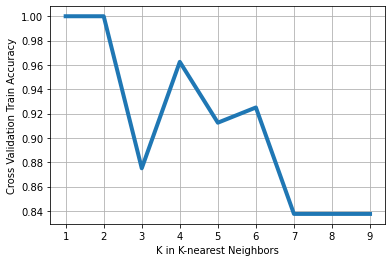

K in KNN vs accuracy (Breast Cancer - Training)


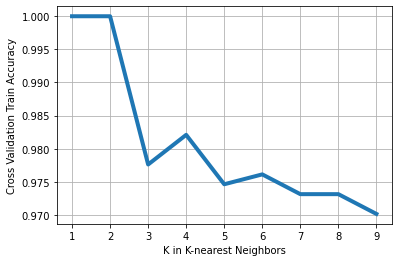


The ideal K for hepatitis is (based on train accuracy): 1
The ideal K for breast cancer is (based on train accuracy): 1
K in KNN vs accuracy (Hepatitis - Testing)


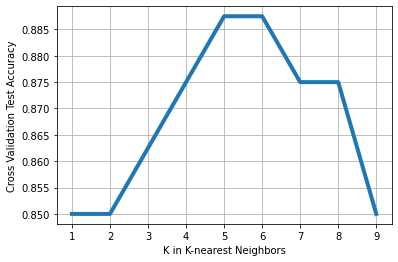

K in KNN vs accuracy (Breast Cancer - Testing)


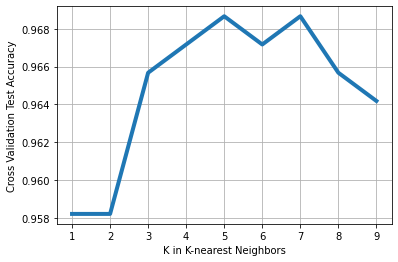


The ideal K for hepatitis is (based on test accuracy): 5
The ideal K for breast cancer is (based on test accuracy): 5


In [49]:
# -----------------------------------------------------------------------------
# 2. Prova diversi valori K e guarda come influisce sui dati di allenamento,
# accuratezza e accuratezza dei dati di test 

# Ks che fornisce la massima precisione (li useremo nei passaggi successivi) 
hepatitis_k = 5
cancer_k = 5


def part2():
    # Precisione del training
    print("K in KNN vs accuracy (Hepatitis - Training)")
    hepatitis_k = KNN.tune_knn_k(hepatitis_df, training=True)
    print("K in KNN vs accuracy (Breast Cancer - Training)")
    cancer_k = KNN.tune_knn_k(cancer_df, training=True)
    print("\nThe ideal K for hepatitis is (based on train accuracy):", hepatitis_k)
    print("The ideal K for breast cancer is (based on train accuracy):", cancer_k)

    # Precisione del testing
    print("K in KNN vs accuracy (Hepatitis - Testing)")
    hepatitis_k = KNN.tune_knn_k(hepatitis_df)
    print("K in KNN vs accuracy (Breast Cancer - Testing)")
    cancer_k = KNN.tune_knn_k(cancer_df)
    print("\nThe ideal K for hepatitis is (based on test accuracy):", hepatitis_k)
    print("The ideal K for breast cancer is (based on test accuracy):", cancer_k)


part2()

Decision tree depth vs accuracy (Hepatitis - Training)


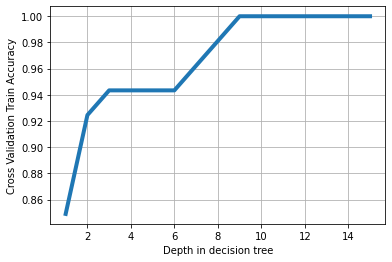

Decision tree depth vs accuracy (Breast cancer - Training)


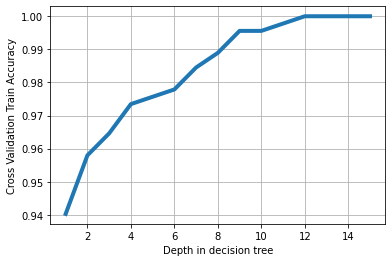


The ideal depth for hepatitis is (based on train accuracy): 9
The ideal depth for breast cancer is (based on train accuracy): 12
Decision tree depth vs accuracy (Hepatitis - Testing)


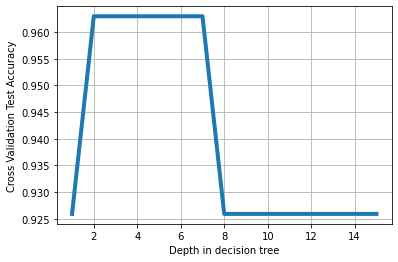

Decision tree depth vs accuracy (Breast cancer - Testing)


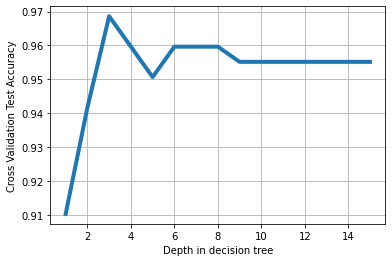


The ideal depth for hepatitis is (based on test accuracy): 2
The ideal depth for breast cancer is (based on test accuracy): 3


In [50]:
# -----------------------------------------------------------------------------
# 3. Verifica in che modo la profondità massima dell'albero può
# influire sulle prestazioni di Decision Tree sui set di dati forniti. 

# Profondità che danno la massima precisione (li useremo nei prossimi passaggi) 
hepatitis_d = 2
cancer_d = 3


def part3():
    print("Decision tree depth vs accuracy (Hepatitis - Training)")
    hepatitis_d = DecisionTree.tune_tree_depth(
        X_train_h, X_test_h, y_train_h, y_test_h, training=True
    )
    print("Decision tree depth vs accuracy (Breast cancer - Training)")
    cancer_d = DecisionTree.tune_tree_depth(
        X_train_c, X_test_c, y_train_c, y_test_c, training=True
    )
    print("\nThe ideal depth for hepatitis is (based on train accuracy):", hepatitis_d)
    print("The ideal depth for breast cancer is (based on train accuracy):", cancer_d)

    print("Decision tree depth vs accuracy (Hepatitis - Testing)")
    hepatitis_d = DecisionTree.tune_tree_depth(X_train_h, X_test_h, y_train_h, y_test_h)
    print("Decision tree depth vs accuracy (Breast cancer - Testing)")
    cancer_d = DecisionTree.tune_tree_depth(X_train_c, X_test_c, y_train_c, y_test_c)
    print("\nThe ideal depth for hepatitis is (based on test accuracy):", hepatitis_d)
    print("The ideal depth for breast cancer is (based on test accuracy):", cancer_d)

part3()

KNN hepatitis P in minkowski distance hyperparamter tuning


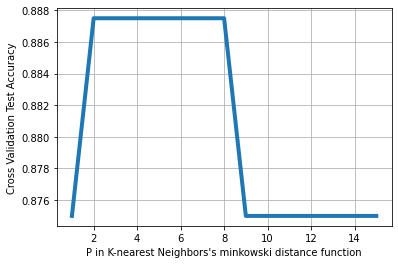

KNN breast cancer P in minkowski distance hyperparamter tuning


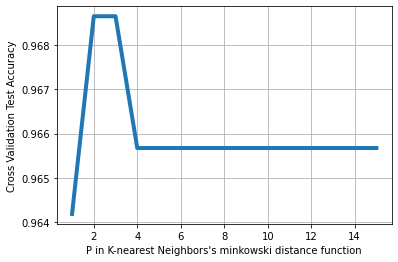


The ideal P for hepatitis minkowski distance function: 2
The ideal P for breast cancer minkowski distance function: 2
Decision tree Hepatitis cost functions vs accuracy
[0.962962962962963, 0.7777777777777778, 0.888888888888889]


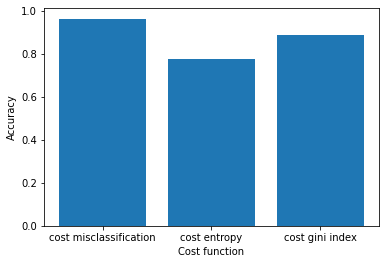


The most accurate cost function for hepatitis dataset: cost_misclassification
Decision tree breast cancer cost functions vs accuracy
[0.9686098654708519, 0.9551569506726457, 0.9551569506726457]


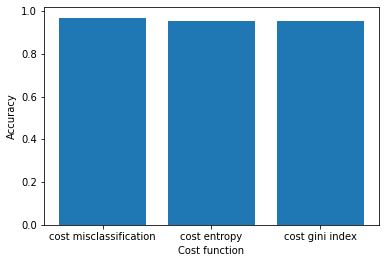


The most accurate cost function for breast cancer  dataset: cost_misclassification


In [51]:
# -----------------------------------------------------------------------------
# 4. Prova diverse funzioni distanza/costo per entrambi i modelli. 
# Trova p ideale nella distanza di minkowski in KNN


def part4():
    print("KNN hepatitis P in minkowski distance hyperparamter tuning")
    hepatitis_p = KNN.tune_knn_p(hepatitis_df)
    print("KNN breast cancer P in minkowski distance hyperparamter tuning")
    cancer_p = KNN.tune_knn_p(cancer_df)
    print("\nThe ideal P for hepatitis minkowski distance function:", hepatitis_p)
    print("The ideal P for breast cancer minkowski distance function:", cancer_p)

    print("Decision tree Hepatitis cost functions vs accuracy")
    hepatitis_cf = DecisionTree.tune_costfn(
        X_train_h, X_test_h, y_train_h, y_test_h, hepatitis_d
    )
    print(
        "\nThe most accurate cost function for hepatitis dataset:",
        hepatitis_cf.__name__,
    )
    print("Decision tree breast cancer cost functions vs accuracy")
    cancer_cf = DecisionTree.tune_costfn(
        X_train_c, X_test_c, y_train_c, y_test_c, cancer_d
    )
    print(
        "\nThe most accurate cost function for breast cancer  dataset:",
        cancer_cf.__name__,
    )

part4()


KNN-breast cancer


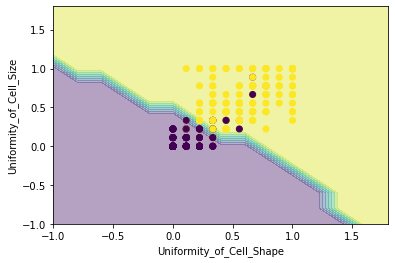

DecisionTree-breast cancer


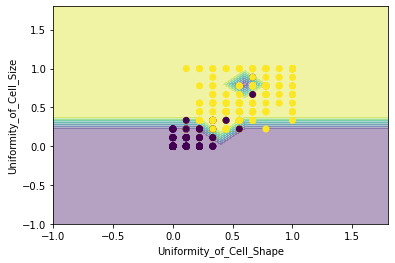

KNN-hepatitis


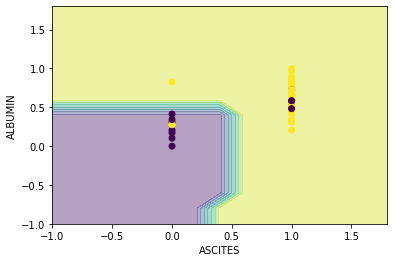

DecisionTree-hepatitis


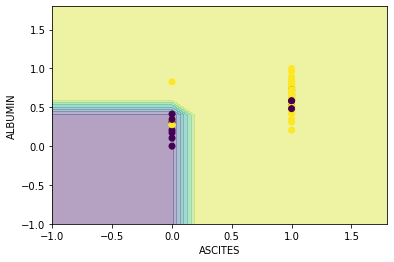

In [56]:
# -----------------------------------------------------------------------------
# 5. Presenta un grafico de confine decisionale per ciascun modello. 


def reduce_df(df, n):
    """Riduce le caratteristiche di un dataframe"""
    reduced_df = df.copy(deep=True)
    corr = correlation(df, plot=False)
    corr = corr.keys()[:n]
    reduced_df = reduced_df[corr]
    return reduced_df


def part5():
    """Prendiamo 2 caratteristiche con correlazione di alta classe per mostrare i confini delle decisioni
     per il cancro al seno: Uniformity_of_Cell_Shape e Uniformity_of_Cell_Size"""
    # Dataset 1
    # KNN
    df = reduce_df(cancer_df, 3)
    cancer_features, cancer_labels = Preprocessing.get_labels_features(df)

    print("KNN-breast cancer")
    KNN.plot_decision_bound(
        cancer_features,
        cancer_labels,
        df.keys()[1],
        df.keys()[2],
        KNN,
        k=cancer_k,
    )
    # Decision Tree
    print("DecisionTree-breast cancer")
    DecisionTree.plot_decision_bound(
        cancer_features,
        cancer_labels,
        df.keys()[1],
        df.keys()[2],
        DecisionTree,
        max_depth=9,
    )

    # Dataset 2
    # KNN
    df = reduce_df(hepatitis_df, 3)
    hepatitis_features, hepatitis_labels = Preprocessing.get_labels_features(df)

    print("KNN-hepatitis")
    KNN.plot_decision_bound(
        hepatitis_features,
        hepatitis_labels,
        df.keys()[1],
        df.keys()[2],
        KNN,
        k=hepatitis_k,
    )
    # Decision Tree
    print("DecisionTree-hepatitis")
    DecisionTree.plot_decision_bound(
        hepatitis_features,
        hepatitis_labels,
        df.keys()[1],
        df.keys()[2],
        DecisionTree,
        max_depth=18,
    )

part5()

In [53]:
# -----------------------------------------------------------------------------
# esperimenti extra (parte6)
# Esaminiamo l'effetto della riduzione del numero di funzionalità con cui formiamo i modelli,
# quindi tracciamo l'accuratezza del modello addestrato con "n" funzionalità correlate
# alla maggior parte delle classi per vedere se vale la pena considerare tutte le funzionalità.



def reduced_df_accuracy(df, model, **kwargs):
    accuracy = []

    ns = np.arange(2, df.shape[1])
    for n in ns:
        df = reduce_df(df, n)
        features, labels = Preprocessing.get_labels_features(df)
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.33
        )
        accuracy.append(
            model.get_mean_accuracy(
                model, X_train, X_test, y_train, y_test, 1, **kwargs
            )
        )

    plt.plot(ns, accuracy, linewidth=4, markersize=10)
    plt.grid()
    plt.xlabel("Number of features given to the model")
    plt.ylabel("Accuracy")
    plt.show()


def part6():
    print("number of features vs accuracy (KNN-cancer)")
    reduced_df_accuracy(cancer_df, KNN, k=cancer_k)
    print("number of features vs accuracy (DecisionTree-cancer)")
    reduced_df_accuracy(cancer_df, DecisionTree, max_depth=cancer_d)

    print("number of features vs accuracy (KNN-Hepatitis)")
    reduced_df_accuracy(hepatitis_df, KNN, k=hepatitis_k)
    print("number of features vs accuracy (DecisionTree-Hepatitis)")
    reduced_df_accuracy(hepatitis_df, DecisionTree, max_depth=hepatitis_d)


def part7():
    """Analizziamo la relazione tra la distribuzione in classi e le caratteristiche
     come TP, TF, FP e FN e la sensibilità. Idealmente vogliamo un modello con alta
     sensibilità """
    # confusion matrix
    # KNN
    print("KNN breast cancer confusion matrix")
    Classifier.plot_confusion_matrix(cancer_features, cancer_labels, KNN, 2, 4, k=5)
    print("KNN hepatitis confusion matrix")
    Classifier.plot_confusion_matrix(
        hepatitis_features, hepatitis_labels, KNN, 1, 2, k=5
    )

    # Decision Tree
    print("Decision tree breast cancer confusion matrix")
    Classifier.plot_confusion_matrix(
        cancer_features, cancer_labels, DecisionTree, 2, 4, max_depth=3
    )
    print("Decision tree hepatitis confusion matrix")
    Classifier.plot_confusion_matrix(
        hepatitis_features, hepatitis_labels, DecisionTree, 1, 2, max_depth=2
    )

number of features vs accuracy (KNN-cancer)


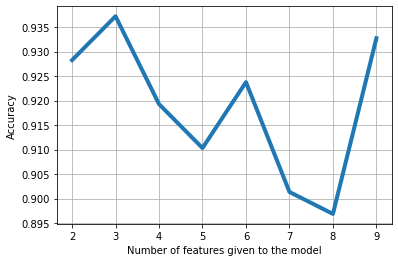

number of features vs accuracy (DecisionTree-cancer)


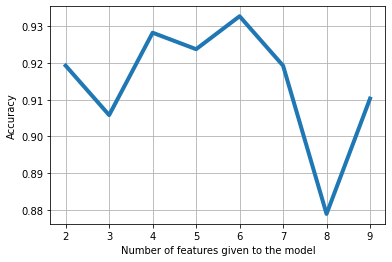

number of features vs accuracy (KNN-Hepatitis)


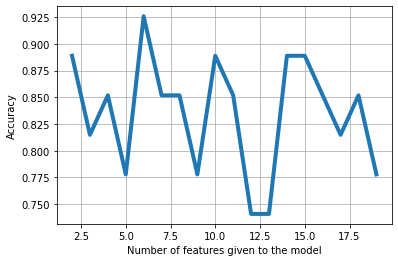

number of features vs accuracy (DecisionTree-Hepatitis)


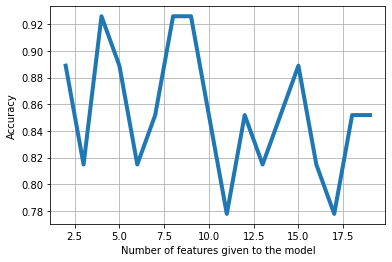

In [54]:
part6()

KNN breast cancer confusion matrix


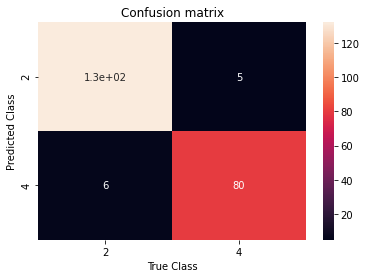

KNN hepatitis confusion matrix


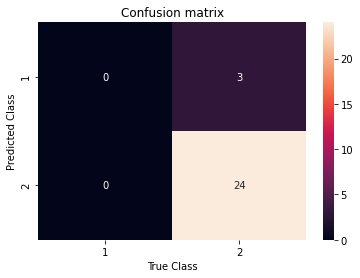

Decision tree breast cancer confusion matrix


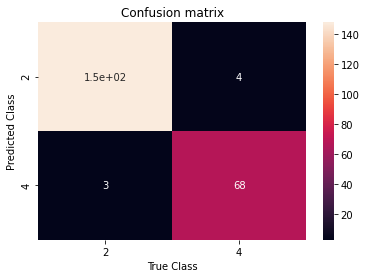

Decision tree hepatitis confusion matrix


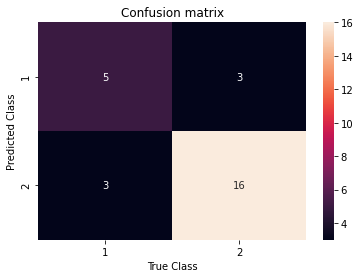

In [55]:
part7()